In [66]:
from djchurchland import *
from djchurchland.schema import * # Imports all schemas from the database
from djchurchland.utils import *
from djchurchland.chipmunk.psychometric import PsychometricFit
from chiCa.chiCa import separate_axes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import uniform_filter1d

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

save_dir = '/Users/gabriel/Desktop/BSN_figures/'

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Single animal plotting

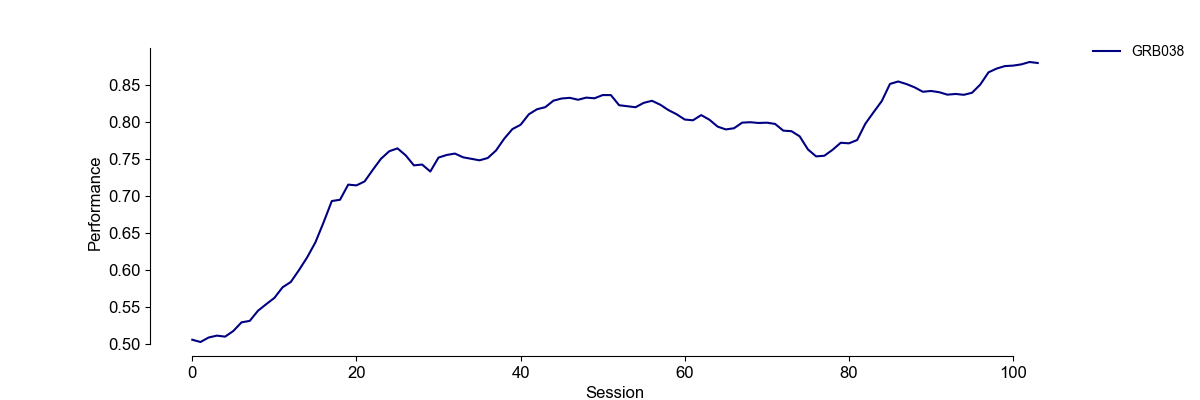

In [67]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
mice = ["GRB038"]
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)

### Multi animal learning plot

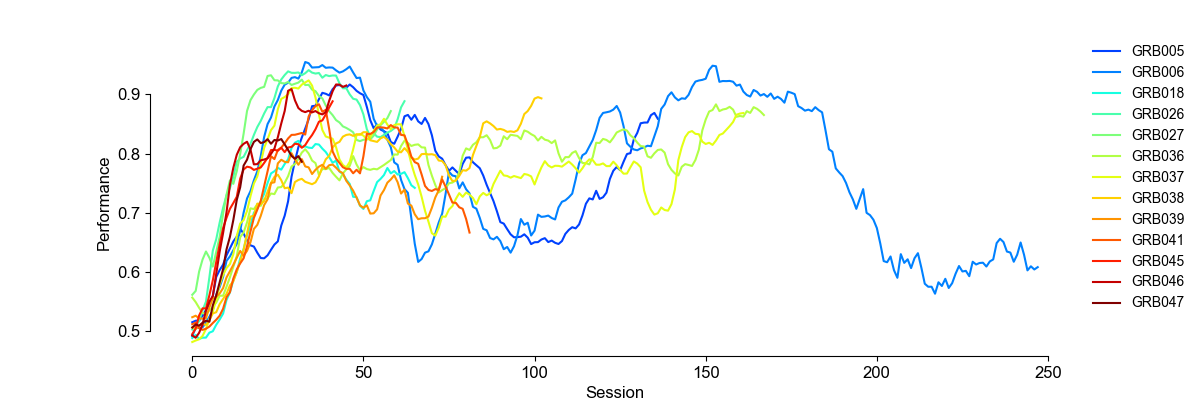

In [3]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

mice = np.unique(PsychometricFit().fetch("subject_name"))
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    if mouse in ["GRB001", "GRB002", "GRB003", "GRB004", "GRB007"]: #mice only trained on 1s wait time version of the task
        continue
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)
# plt.savefig(pjoin(save_dir, 'performance_across_learning.svg'), format='svg', dpi=300, bbox_inches='tight')

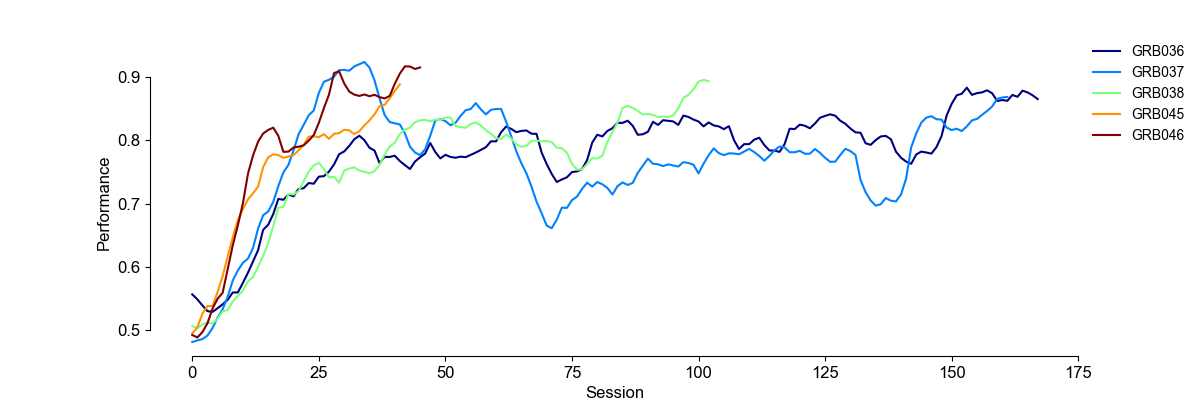

In [4]:
window_size = 10
fig, ax = plt.subplots(figsize=(12, 4))
mice = ["GRB036", "GRB037", "GRB038", "GRB045", "GRB046"]
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(mice)))
for mouse, color in zip(mice, colors):
    
    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    # Calculate average of first and last performance values and create new dataframe
    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))
    }).dropna().reset_index()

    y = uniform_filter1d(easy_perf_df.avg_performance, size=window_size)

    ax.plot(y, color = color, alpha = 1, label = f"{mouse}")

ax.set_xlabel('Session')
ax.set_ylabel('Performance')
ax.legend(fontsize=10, frameon=False, bbox_to_anchor=(1, 1.05));
separate_axes(ax)

In [139]:
good_trials = (Chipmunk.Trial() & "subject_name = 'GRB046'" & "session_datetime LIKE '2025-08-12%'" & "with_choice = 1").fetch('trial_number')

initiation_time, pre_stim_time, response = (Chipmunk.Trial() & "subject_name = 'GRB046'" & "session_datetime LIKE '2025-08-12%'" & f'trial_number IN {tuple(good_trials)}').fetch(
    "initiation_time", "pre_stim_time", "response")

rewarded, response_time = (Chipmunk.Trial() & "subject_name = 'GRB046'" & "session_datetime LIKE '2025-08-12%'" & "with_choice = 1").fetch(
    "rewarded", "response_time")

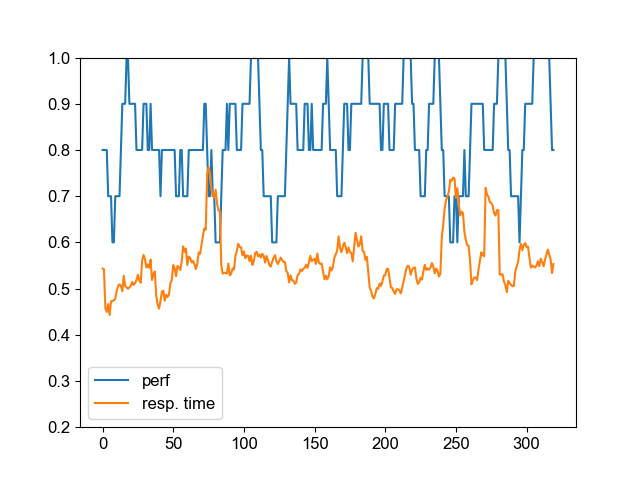

In [140]:
weights = np.ones(10)/10

rw_avg = np.convolve(rewarded, weights, mode='valid')
rt_avg = np.convolve(response_time, weights, mode='valid')

plt.figure()
plt.plot(rw_avg, label='perf')
plt.plot(rt_avg, label = 'resp. time')
plt.ylim([0.2, 1])
plt.legend();

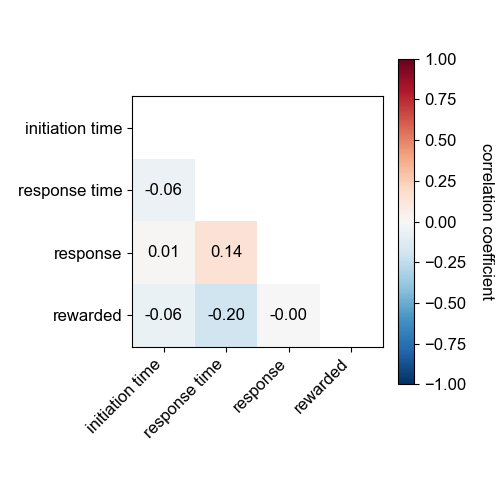

In [137]:
fig, ax = plt.subplots(figsize=(5, 5))

data = np.array([initiation_time, response_time, response, rewarded])
labels = ['initiation time', 'response time', 'response', 'rewarded']

corr_matrix = np.corrcoef(data)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
masked_corr = np.ma.masked_array(corr_matrix, mask=mask)

im = ax.imshow(masked_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        if i > j:
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha='center', va='center', 
                          color='white' if abs(corr_matrix[i, j]) > 0.5 else 'black')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('correlation coefficient', rotation=270, labelpad=20)
plt.tight_layout()
